# Regressione lineare multipla

## Ottenimento del dataset

Contenuto del DataFrame:
   UserID  Age  Gender       VRHeadset   Duration  MotionSickness  \
0       1   40       2        HTC Vive  13.598508               8   
1       2   43       1        HTC Vive  19.950815               2   
2       3   27       2  PlayStation VR  16.543387               4   
3       4   33       2        HTC Vive  42.574083               6   
4       5   51       2  PlayStation VR  22.452647               4   

   ImmersionLevel  
0               5  
1               2  
2               2  
3               3  
4               2  


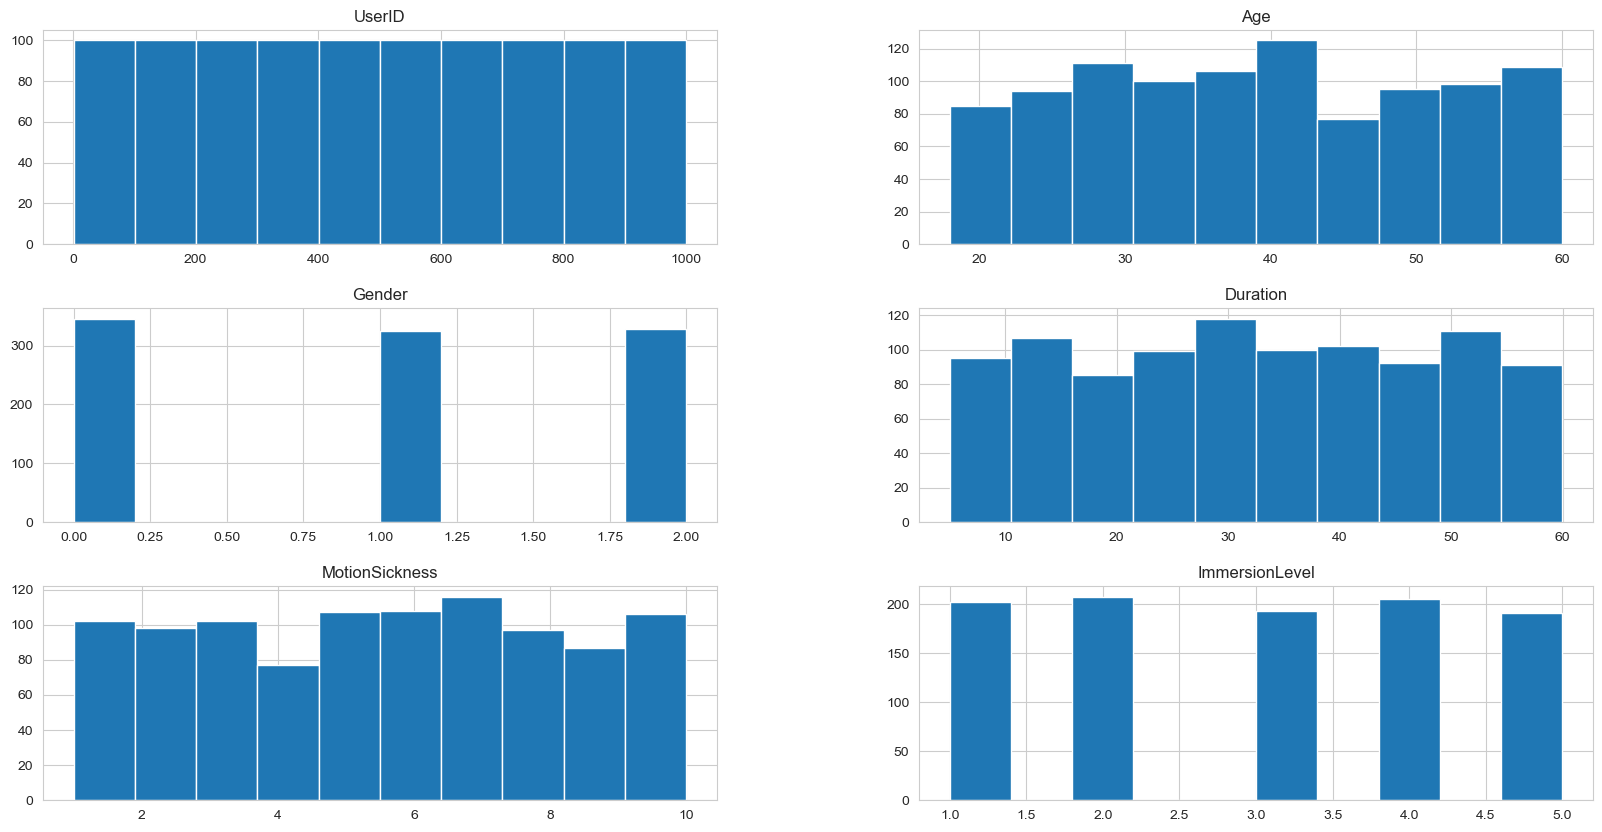

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from six.moves import urllib
import seaborn as sb
from matplotlib import style

sb.set_style('whitegrid')

plt.rcParams['figure.figsize'] = (20, 10)

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/everysimo/MetaClass_IA_Meeting/master/data.csv"
FILE_PATH = "file"
FILE_NAME = "data.csv"
CSV_PATH = os.path.join(FILE_PATH, FILE_NAME)

# fetch dataset da github
def fetch_file_data1(file_url=DOWNLOAD_ROOT, file_path=FILE_PATH, file_name=FILE_NAME):
    os.makedirs(file_path, exist_ok=True)
    csv_path = os.path.join(file_path, file_name)
    urllib.request.urlretrieve(file_url, csv_path)

fetch_file_data1()

# Verifica il contenuto del file scaricato
try:
    df = pd.read_csv(CSV_PATH)
    print("Contenuto del DataFrame:")
    print(df.head())
    # Visualizza l'istogramma
    df.hist()
    plt.show()
except pd.errors.EmptyDataError:
    print("Il file CSV è vuoto.")
except pd.errors.ParserError:
    print("Errore di parsing del file CSV.")
except Exception as e:
    print(f"Errore sconosciuto: {e}")


## 1)DataCleaning

### 1.1) Descrizione del dataset

In [3]:
#descrizione dataset
df.describe()

,UserID,Age,Gender,Duration,MotionSickness,ImmersionLevel
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,39.178000,0.983000,32.576660,5.526000,2.976000
std,288.819436,12.050208,0.821819,15.764659,2.866625,1.409756
min,1.000000,18.000000,0.000000,5.008672,1.000000,1.000000
25%,250.750000,29.000000,0.000000,18.733748,3.000000,2.000000
50%,500.500000,39.000000,1.000000,32.368611,6.000000,3.000000
75%,750.250000,49.000000,2.000000,45.343732,8.000000,4.000000
max,1000.000000,60.000000,2.000000,59.983723,10.000000,5.000000


### 1.2) Verifica valori null nel dataset

In [ ]:
#verifica se ci sono dati null nel dataset
df.isnull().any()

UserID            False
Age               False
Gender            False
VRHeadset         False
Duration          False
MotionSickness    False
ImmersionLevel    False
dtype: bool

### 1.3) Verifica valori N/A nel dataset

In [ ]:
#verifica se ci sono dati NA nel dataset
df.isna().any()

UserID            False
Age               False
Gender            False
VRHeadset         False
Duration          False
MotionSickness    False
ImmersionLevel    False
dtype: bool

###1.4) Data Plot

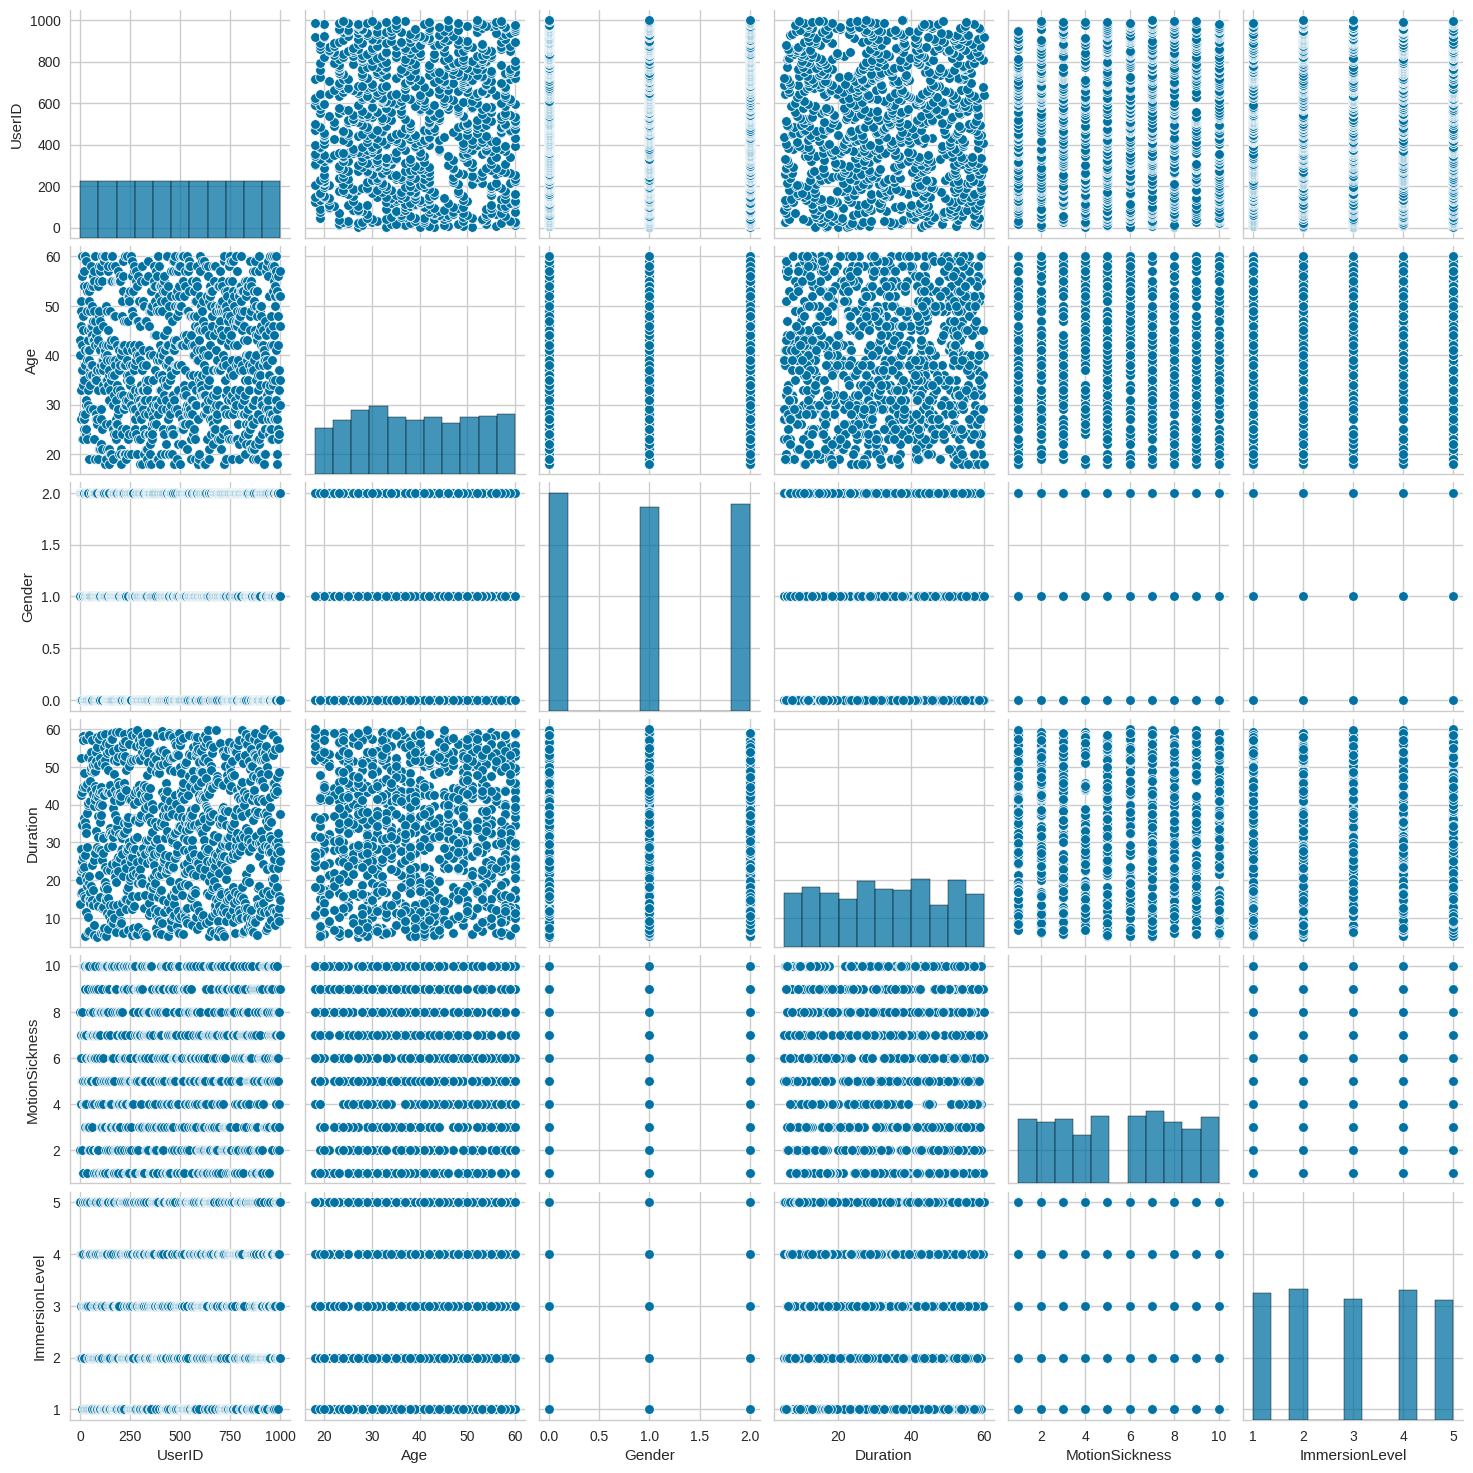

In [ ]:
#data plot visualizzare dipendenze tra variabili
sb.pairplot(df)
#salvataggio plot
plt.savefig('pairplor.png')

###1.5) Plot Linearità e Multicollinearità

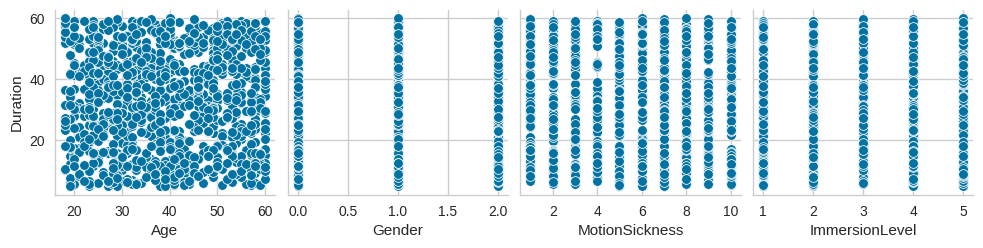

In [ ]:
#Data plot su un sottoinsieme preso in esame
sb.pairplot(df,x_vars=["Age","Gender", "MotionSickness", "ImmersionLevel"], y_vars=["Duration"])
#salvataggio linear plot
plt.savefig('linearPlot.png')

<Axes: >

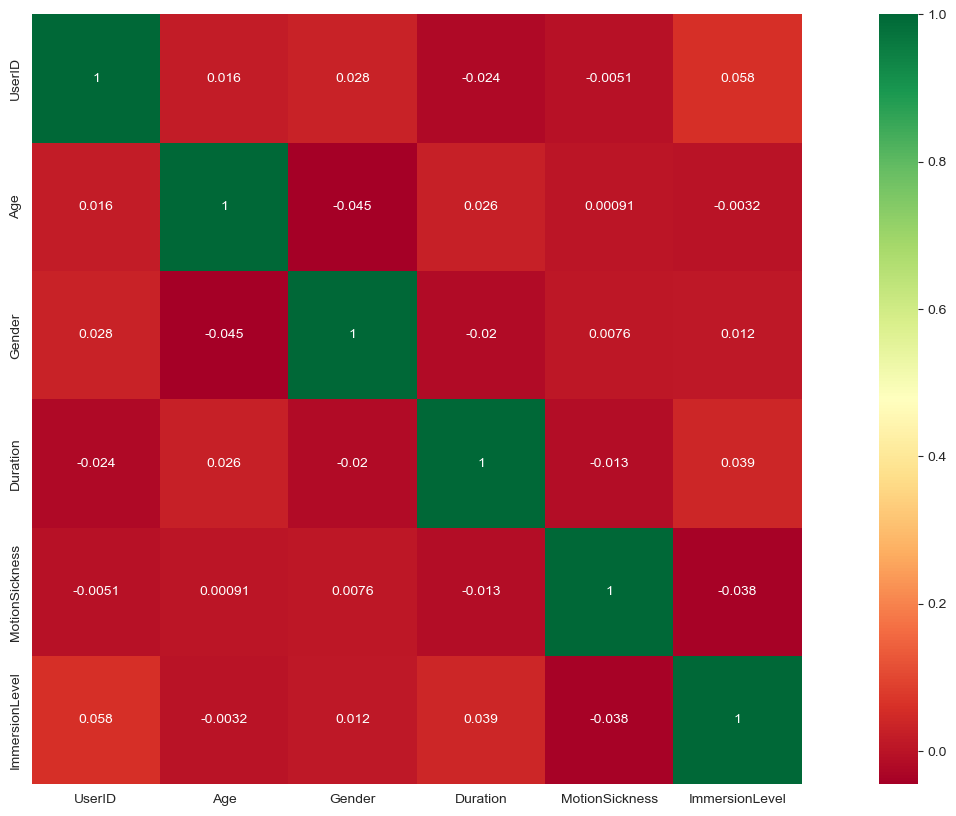

In [4]:
#correlazione tra le variabili
sb.heatmap(df.corr(numeric_only=True), annot=True, cmap="RdYlGn", square=True)

## 2)Divisione in Training e Test Sets, Feature Selection

###2.1) Definizione classe Metrics

In [7]:
#oggetto che contiene le metriche
class Metrics1:
  #costruttore
  def __init__(self,mae,mse,rmse):
    self.mae=mae
    self.mse=mse
    self.rmse=rmse

  #ToString
  def __str__(self):
    return f'Metrics [mae= {self.mae} mse= {self.mse} rmse= {self.rmse} mean= {np.mean([self.mae,self.mse,self.rmse])}'

###2.2) Definizione classe MetricsResultContainer

In [10]:
#classe per contenere risultato delle metriche
class MetricsResultContainer:
  meanMAE = []
  meanMSE = []
  meanRMSE = []
  #costruttore
  def __init__(self,model,alg,scaler,param,metricsMean):
    self.model=model
    self.alg=alg
    self.scaler=scaler
    self.param=param
    self.metricsMean=metricsMean
    self.meanMAE = []
    self.meanMSE = []
    self.meanRMSE = []
  #funzione per stampare metriche
  def printMetrics(self):
    for m in self.metricsMean:
      self.meanMAE.append(m.mae)
      self.meanMSE.append(m.mse)
      self.meanRMSE.append(m.rmse)
    print("meanMAE=",np.mean(self.meanMAE))
    print("meanMSE=",np.mean(self.meanMSE))
    print("meanRMSE=",np.mean(self.meanRMSE))

### 2.3) Istanziazione funzioni per Regressione

In [16]:
#pipeline per istallare termcolor
!pip install termcolor

  Obtaining dependency information for termcolor from https://files.pythonhosted.org/packages/d9/5f/8c716e47b3a50cbd7c146f45881e11d9414def768b7cd9c5e6650ec2a80a/termcolor-2.4.0-py3-none-any.whl.metadata


In [ ]:
#pipeline per installare yellowbrick
!pip install yellowbrick

In [27]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

from sklearn import metrics
from sklearn.datasets import load_iris
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, f_regression
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.base import clone

from yellowbrick.regressor import ResidualsPlot
from yellowbrick.base import Visualizer

from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.compat import lzip

from termcolor import colored as cl

#funzione per generare il modello, divisione training e test, features scaling, selection
def generateModel(alg, scaler, model, select):
  #array di metriche (MAE,MSE,RMSE)
  metrics1 = []
  #generazione n_split test/trainig sets
  #uso algoritmo per dividere i dati di raining da quelli di test
  for train_index, test_index in alg.split(X,y):
    clone_model = clone(model)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    #feature scaling sui traing test
    X_train_z = scaler.fit_transform(X_train)
    X_test_z = scaler.transform(X_test)
    #applicazione feature selection su train_z
    X_train_z = select.fit_transform(X_train_z, y_train)
    X_test_z = select.transform(X_test_z)

    #training dell'algoritmo sui training set
    clone_model.fit(X_train_z,y_train)
    #validazione modello e applicazione predizione sui testSet
    y_pred = clone_model.predict(X_test_z)
    modelCopy = copy.copy(clone_model)
    #calcolo metriche predizione
    metrics1.append(
        Metrics1(metrics.mean_absolute_error(y_test,y_pred),
                 metrics.mean_squared_error(y_test,y_pred),
                 np.sqrt(metrics.mean_squared_error(y_test,y_pred))
                 )
        ) 
    
  return metrics1


#Scelta variabile dipendente (y) e indipendenti (X)
X=df.drop(columns=['Duration','VRHeadset','UserID'])
y=df.Duration
#numero record nel dataset
k=len(df)
#calcolo k ideale da usare nelle tecniche di validazione deve essere il 30% della lunghezza del dataset
k= (k/(k*0.1))
#Kf divisione dataset per k gruppi per testare mediante due algoritmi Kfold-RepeateKFold
kf = KFold(n_splits=int(np.ceil(k)),random_state=42, shuffle=True)
#rKf con k gruppi, e 10 ripetizioni
rkf = RepeatedKFold(n_splits=int(np.ceil(k)), n_repeats=100, random_state=42)
#rkf con 3 gruppi e 10 ripetizioni per questioni  di utilizzo della ram messa a disposizione da google
rkfRF = RepeatedKFold(n_splits=3, n_repeats=10, random_state=42)
#instanziazione algritmo per selezione dei KBest individui
select = SelectKBest(f_regression, k=4)
#risultati: array di array di metriche
metricsResults = []

## 3) Model Testing

### 3.1) Linear Regression

In [28]:
from sklearn.linear_model import LinearRegression
#Linear Regression
#stampa le metriche uscenti dall'algoritmo utilizzato ovvero ZScore e KFold
print("Linear Regression - ZScore Normalization - KF")
m = MetricsResultContainer("Linear Regression","KF","ZScore","Default",
  generateModel(kf, StandardScaler(),  LinearRegression(), select)
)
metricsResults.append(m)
m.printMetrics()
#stampa le metriche uscenti dall'algoritmo utilizzato ovvero ZScore e RKFold
print("\nLinear Regression - ZScore Normalization - RKF")
m = MetricsResultContainer("Linear Regression","RKF","ZScore","Default",
  generateModel(rkf, StandardScaler(),  LinearRegression(), select)
)
metricsResults.append(m)
m.printMetrics()
#stampa le metriche uscenti dall'algoritmo utilizzato ovvero Minimax e KFold
print("\nLinear Regression - MinMax Normalization - KF")
m = MetricsResultContainer("Linear Regression","KF","MinMax","Default",
  generateModel(kf, MinMaxScaler(),  LinearRegression(), select)
)
metricsResults.append(m)
m.printMetrics()
#stampa le metriche uscenti dall'algoritmo utilizzato ovvero Minmax e RKFold
print("\nLinear Regression - MinMax Normalization - RKF")
m = MetricsResultContainer("Linear Regression","RKF","MinMax","Default",
  generateModel(rkf, MinMaxScaler(),  LinearRegression(), select)
)
metricsResults.append(m)
m.printMetrics()
#stampa le metriche uscenti dall'algoritmo utilizzato ovvero RobustScaler e KFold
print("\nLinear Regression - RobustScaler Normalization - KF")
m = MetricsResultContainer("Linear Regression","KF","RobustScaler","Default",
  generateModel(kf, RobustScaler(),  LinearRegression(), select)
)
metricsResults.append(m)
m.printMetrics()
#stampa le metriche uscenti dall'algoritmo utilizzato ovvero RobustScaler e RKFold
print("\nLinear Regression - RobustScaler Normalization - RKF")
m = MetricsResultContainer("Linear Regression","RKF","RobustScaler","Default",
  generateModel(rkf, RobustScaler(), LinearRegression(), select)
)
metricsResults.append(m)
m.printMetrics()

Linear Regression - ZScore Normalization - KF
Metrics [mae= 12.559657945855562 mse= 222.23685882585713 rmse= 14.907610768525489 mean= 83.23470918007939
Metrics [mae= 14.334560668160774 mse= 262.60986492732854 rmse= 16.205241896600263 mean= 97.71655583069652
Metrics [mae= 13.721652051649269 mse= 248.65809020840658 rmse= 15.768896290115126 mean= 92.71621285005699
Metrics [mae= 12.29906694401017 mse= 217.8548393691552 rmse= 14.759906482398701 mean= 81.63793759852136
Metrics [mae= 13.524886357067311 mse= 251.2803701933929 rmse= 15.851825453031992 mean= 93.55236066783074
Metrics [mae= 14.136018273931716 mse= 266.269958507291 rmse= 16.317780440589676 mean= 98.90791907393746
Metrics [mae= 14.195922941716562 mse= 258.42352068298413 rmse= 16.07555662124905 mean= 96.23166674864991
Metrics [mae= 13.397224380685719 mse= 243.23995374956897 rmse= 15.596151889154227 mean= 90.74444333980297
Metrics [mae= 13.806468767245034 mse= 250.59662393405756 rmse= 15.830243963188234 mean= 93.41111222149694
Metric

Metrics [mae= 13.352850916815889 mse= 241.18365578513595 rmse= 15.53008872431629 mean= 90.02219847542271
Metrics [mae= 13.298561905497916 mse= 245.73145801001363 rmse= 15.675823997800359 mean= 91.56861463777064
Metrics [mae= 13.151178130478515 mse= 239.416456536422 rmse= 15.473088138326558 mean= 89.34690760174236
Metrics [mae= 14.272734728634116 mse= 265.8621140801692 rmse= 16.30527871826082 mean= 98.81337584235472
Metrics [mae= 12.934992423931988 mse= 245.21842042357028 rmse= 15.65945147262733 mean= 91.27095477337654
Metrics [mae= 13.801293861868302 mse= 257.9698184850386 rmse= 16.06143886720734 mean= 95.94418373803809
Metrics [mae= 13.548362255595839 mse= 242.3075909789269 rmse= 15.5662323951214 mean= 90.47406187654803
Metrics [mae= 15.429732481043127 mse= 301.1242006602362 rmse= 17.352930607255832 mean= 111.30228791617839
Metrics [mae= 13.58254601290146 mse= 248.32678506633812 rmse= 15.758387768624623 mean= 92.5559062826214
Metrics [mae= 12.835434263807052 mse= 228.8463353957826 rms

Metrics [mae= 11.896716785041194 mse= 207.29888136863875 rmse= 14.397877668901023 mean= 77.86449194086033
Metrics [mae= 12.690245303357312 mse= 219.83798053191484 rmse= 14.826934293100338 mean= 82.45172004279083
Metrics [mae= 13.89914113990654 mse= 258.26753752458205 rmse= 16.070704325715848 mean= 96.07912766340148
Metrics [mae= 15.058321310665479 mse= 287.86100725799605 rmse= 16.966467141334878 mean= 106.6285985699988
Metrics [mae= 13.76695009906481 mse= 257.3791265154421 rmse= 16.043039815304397 mean= 95.72970547660377
Metrics [mae= 14.062212094093265 mse= 265.64261427073615 rmse= 16.298546385206755 mean= 98.66779091667871
Metrics [mae= 13.358715853480094 mse= 244.6944091260953 rmse= 15.64271105422891 mean= 91.23194534460144
Metrics [mae= 14.5197394787742 mse= 276.9847996935763 rmse= 16.64286032187906 mean= 102.71579983140987
Metrics [mae= 14.46369311333613 mse= 269.4378240398299 rmse= 16.414561341681654 mean= 100.10535949828255
Metrics [mae= 12.65601934970153 mse= 213.58629362109954

Metrics [mae= 13.646692888396512 mse= 242.03198187188755 rmse= 15.557377088439026 mean= 90.4120172829077
Metrics [mae= 14.12828429793268 mse= 257.4433364712271 rmse= 16.04504086848105 mean= 95.87222054588028
Metrics [mae= 13.51890968425731 mse= 251.27020488324032 rmse= 15.851504814472358 mean= 93.54687312732334
Metrics [mae= 13.176474922220372 mse= 231.41442284123605 rmse= 15.212311554830714 mean= 86.60106977276239
Metrics [mae= 13.638028554397222 mse= 262.54871313120645 rmse= 16.203354996148374 mean= 97.46336556058402
Metrics [mae= 14.005606451438036 mse= 261.9496355678939 rmse= 16.184858218961757 mean= 97.38003341276458
Metrics [mae= 12.355977734998326 mse= 214.3950420142393 rmse= 14.642234870887684 mean= 80.46441820670843
Metrics [mae= 14.046142905151557 mse= 267.53146300771243 rmse= 16.356389057726417 mean= 99.31133165686346
Metrics [mae= 14.602454123831752 mse= 278.5333455382312 rmse= 16.68931830657655 mean= 103.27503932287982
Metrics [mae= 13.168439582298985 mse= 234.294214413584

Metrics [mae= 12.961324945706767 mse= 227.4710707735207 rmse= 15.082144103990013 mean= 85.17151327440583
Metrics [mae= 13.875520807806513 mse= 267.5227500354512 rmse= 16.35612270788683 mean= 99.25146451704819
Metrics [mae= 13.94225136673994 mse= 254.72577480771105 rmse= 15.960130789179361 mean= 94.87605232121011
Metrics [mae= 13.361884397330071 mse= 241.05099489951937 rmse= 15.525817044507493 mean= 89.97956544711899
Metrics [mae= 15.346302726905437 mse= 305.6924722964093 rmse= 17.48406338058774 mean= 112.84094613463417
Metrics [mae= 13.96904820079666 mse= 252.84342638102228 rmse= 15.901051109314198 mean= 94.23784189704439
Metrics [mae= 14.188232296890465 mse= 269.8676848552414 rmse= 16.42765001012748 mean= 100.16118905408645
Metrics [mae= 13.989096638294491 mse= 263.1776703992522 rmse= 16.22275162847697 mean= 97.79650622200786
Metrics [mae= 12.996059160167388 mse= 229.85681513304206 rmse= 15.161029487902267 mean= 86.0046345937039
Metrics [mae= 13.411110663037965 mse= 237.52296842582365

Metrics [mae= 13.113865306350787 mse= 242.01389651032093 rmse= 15.556795830450463 mean= 90.22818588237406
Metrics [mae= 14.977854884012686 mse= 293.6525749088696 rmse= 17.1362940832862 mean= 108.58890795872283
Metrics [mae= 14.296129642202002 mse= 269.5600642136205 rmse= 16.41828444794463 mean= 100.09149276792238
Metrics [mae= 13.56105661241952 mse= 243.35500282118505 rmse= 15.599839833190117 mean= 90.83863308893156
Metrics [mae= 13.448909609814212 mse= 247.4687735140913 rmse= 15.731140248376509 mean= 92.21627445742735
Metrics [mae= 13.439537357670984 mse= 238.71010499450014 rmse= 15.450246114366598 mean= 89.19996282217924
Metrics [mae= 13.415272513024094 mse= 247.67043630568733 rmse= 15.73754861170212 mean= 92.27441914347118
Metrics [mae= 13.754866351932654 mse= 256.36503880719937 rmse= 16.011403399052796 mean= 95.37710285272829
Metrics [mae= 12.810342788440357 mse= 231.3720255838917 rmse= 15.210917973084062 mean= 86.46442878180538
Metrics [mae= 13.184902850723807 mse= 231.66406029624

Metrics [mae= 13.674242819054397 mse= 245.5549429705278 rmse= 15.670192818549738 mean= 91.63312620271064
Metrics [mae= 14.043401171467654 mse= 256.9927967283495 rmse= 16.030994876437006 mean= 95.68906425875139
Metrics [mae= 13.891276268561429 mse= 255.9535495249892 rmse= 15.998548356803788 mean= 95.2811247167848
Metrics [mae= 14.331788611452412 mse= 276.40679701788724 rmse= 16.625486369363372 mean= 102.45469066623434
Metrics [mae= 14.000571583034914 mse= 257.7780367088679 rmse= 16.055467502033938 mean= 95.94469193131225
Metrics [mae= 13.797242022801525 mse= 256.2519802549603 rmse= 16.007872446235954 mean= 95.35236490799927
Metrics [mae= 13.238038351433186 mse= 239.37199729159812 rmse= 15.471651408030047 mean= 89.36056235035379
Metrics [mae= 11.87759974648598 mse= 199.29640928174476 rmse= 14.1172380188812 mean= 75.09708234903731
Metrics [mae= 13.334547363777084 mse= 241.97780395776132 rmse= 15.555635761927615 mean= 90.289329027822
Metrics [mae= 13.569632441162486 mse= 237.99623655261894

Metrics [mae= 12.40947104663376 mse= 205.89719998636014 rmse= 14.349118439345329 mean= 77.55192982411307
Metrics [mae= 14.583708347096696 mse= 275.70404701757855 rmse= 16.604338198723205 mean= 102.29736452113282
Metrics [mae= 14.34657130613374 mse= 273.36620006910647 rmse= 16.533789646330526 mean= 101.41552034052359
Metrics [mae= 12.292425784074112 mse= 221.04420192713144 rmse= 14.867555344680289 mean= 82.73472768529528
Metrics [mae= 14.217508350728096 mse= 257.91977214239955 rmse= 16.059880825909 mean= 96.06572043967888
Metrics [mae= 13.221534145975284 mse= 234.7991290513297 rmse= 15.32315662816672 mean= 87.78127327515723
Metrics [mae= 12.95715852617511 mse= 235.03510133338102 rmse= 15.330854553265484 mean= 87.77437147094054
Metrics [mae= 14.430531834818451 mse= 267.81290119432634 rmse= 16.364990106759194 mean= 99.53614104530133
Metrics [mae= 13.558639158794731 mse= 249.81256630778248 rmse= 15.805460015696553 mean= 93.05888849409125
Metrics [mae= 13.295435996539732 mse= 240.7001483266

Metrics [mae= 14.021107148887788 mse= 264.85997831497536 rmse= 16.27451929597232 mean= 98.38520158661181
Metrics [mae= 12.479226424136971 mse= 232.19718799662482 rmse= 15.23801784999036 mean= 86.63814409025072
Metrics [mae= 13.175142803468436 mse= 234.38120696248185 rmse= 15.309513609598506 mean= 87.62195445851627
Metrics [mae= 13.839051800942633 mse= 247.84998139401878 rmse= 15.743251931987203 mean= 92.47742837564954
Metrics [mae= 14.411792713318844 mse= 259.2122227516402 rmse= 16.10006902940606 mean= 96.57469483145503
Metrics [mae= 14.803961811888199 mse= 283.5352313353358 rmse= 16.83850442691796 mean= 105.05923252471399
Metrics [mae= 13.462476711423909 mse= 248.84604991105098 rmse= 15.77485498859026 mean= 92.69446053702173
Metrics [mae= 13.061103077224354 mse= 240.73270225794727 rmse= 15.515563227222763 mean= 89.76978952079811
Metrics [mae= 13.133593450446904 mse= 233.67095643612652 rmse= 15.286299631896744 mean= 87.36361650615673
Metrics [mae= 13.20883359726922 mse= 238.23913666764

Metrics [mae= 13.720720346089326 mse= 259.55727759669463 rmse= 16.110781408631137 mean= 96.46292645047168
Metrics [mae= 12.990987181724945 mse= 228.94015745449295 rmse= 15.130768567871659 mean= 85.68730440136318
Metrics [mae= 13.270718838518984 mse= 242.08026558438004 rmse= 15.558928805813723 mean= 90.30330440957091
Metrics [mae= 14.668525597476624 mse= 276.36029393491475 rmse= 16.624087762488344 mean= 102.55096909829324
Metrics [mae= 13.991866460157247 mse= 257.8538989147471 rmse= 16.057829832039793 mean= 95.96786506898138
Metrics [mae= 13.289680150074858 mse= 246.64560122449976 rmse= 15.704954671201689 mean= 91.88007868192544
Metrics [mae= 13.595425776750549 mse= 254.4859355276206 rmse= 15.952615319364426 mean= 94.67799220791187
Metrics [mae= 12.81179041248157 mse= 221.95298507738033 rmse= 14.898086624710581 mean= 83.22095403819083
Metrics [mae= 12.010679586135968 mse= 204.13403458854293 rmse= 14.287548235738102 mean= 76.81075413680567
Metrics [mae= 13.501492849611637 mse= 249.300753

Metrics [mae= 14.737643896062396 mse= 269.2469937720849 rmse= 16.408747477247765 mean= 100.13112838179836
Metrics [mae= 14.217307842283486 mse= 264.8695433016713 rmse= 16.27481315719696 mean= 98.4538881003839
Metrics [mae= 12.913239027526188 mse= 234.89671017860917 rmse= 15.32634040397802 mean= 87.71209653670445
Metrics [mae= 13.672673867079196 mse= 251.9419394043142 rmse= 15.872679024169619 mean= 93.82909743185434
Metrics [mae= 13.894667098417319 mse= 259.73887437774096 rmse= 16.116416300708448 mean= 96.58331925895557
Metrics [mae= 13.599966522643617 mse= 251.55579100245544 rmse= 15.860510426920548 mean= 93.67208931733985
Metrics [mae= 13.006885334071596 mse= 231.90967538299586 rmse= 15.228580872261075 mean= 86.71504719644285
Metrics [mae= 12.927847612288247 mse= 226.86915464741077 rmse= 15.06217629187133 mean= 84.95305951719011
Metrics [mae= 12.721591685553117 mse= 222.81669585712666 rmse= 14.927045784652993 mean= 83.48844444244425
Metrics [mae= 13.668371328089131 mse= 253.4227944477

Metrics [mae= 13.458772671883144 mse= 249.88007004632277 rmse= 15.807595327763257 mean= 93.04881268198972
Metrics [mae= 13.781560705304784 mse= 247.13308862051625 rmse= 15.72046718836677 mean= 92.21170550472927
Metrics [mae= 13.739715033424117 mse= 249.98615032190807 rmse= 15.810950329499745 mean= 93.17893856161065
Metrics [mae= 12.858042880381705 mse= 230.21707272073832 rmse= 15.172905875959895 mean= 86.0826738256933
Metrics [mae= 13.226177582628495 mse= 242.39289957937987 rmse= 15.568972335365615 mean= 90.39601649912466
Metrics [mae= 13.799165959671422 mse= 254.50142090201973 rmse= 15.953100667331718 mean= 94.75122917634097
Metrics [mae= 13.411282438991478 mse= 246.00919778169867 rmse= 15.684680353188543 mean= 91.70172019129289
Metrics [mae= 13.156073947357266 mse= 245.78925195012755 rmse= 15.677667299382506 mean= 91.5409977322891
Metrics [mae= 14.87808869269375 mse= 281.46546757873267 rmse= 16.77693260339126 mean= 104.37349629160587
Metrics [mae= 12.786129636981382 mse= 223.83653411

Metrics [mae= 14.294015456146798 mse= 277.1372767332268 rmse= 16.647440546018682 mean= 102.69291091179743
Metrics [mae= 14.644007609382804 mse= 274.66376248710367 rmse= 16.5729829085504 mean= 101.96025100167896
Metrics [mae= 14.265671830686705 mse= 260.0409009146066 rmse= 16.12578373024414 mean= 96.81078549184582
Metrics [mae= 13.291736343755211 mse= 244.42799120434708 rmse= 15.634193014170801 mean= 91.1179735207577
Metrics [mae= 12.806055050302307 mse= 226.7246803172206 rmse= 15.057379596637013 mean= 84.86270498805331
Metrics [mae= 14.314063308056552 mse= 268.6914616162305 rmse= 16.391810809554585 mean= 99.79911191128058
Metrics [mae= 13.893681176776987 mse= 266.47280340643675 rmse= 16.32399471350186 mean= 98.89682643223853
Metrics [mae= 12.660689855246826 mse= 212.0311000293485 rmse= 14.561287718788764 mean= 79.7510258677947
Metrics [mae= 14.27384651453307 mse= 264.99834526640797 rmse= 16.278769771282104 mean= 98.51698718407438
Metrics [mae= 12.824628951058084 mse= 223.24196541871052

Metrics [mae= 14.263660675479263 mse= 275.0151209720628 rmse= 16.583579859971813 mean= 101.95412050250462
Metrics [mae= 13.175294656693659 mse= 237.7325524147323 rmse= 15.418578158012247 mean= 88.7754750764794
Metrics [mae= 15.341419809567032 mse= 285.0797248208516 rmse= 16.884304096433812 mean= 105.76848290895082
Metrics [mae= 15.0325928441426 mse= 288.11225856404747 rmse= 16.973869875901826 mean= 106.70624042803063
Metrics [mae= 14.81811539995092 mse= 291.08170307452514 rmse= 17.061116700688885 mean= 107.6536450583883
Metrics [mae= 12.761018517979643 mse= 228.12486397378635 rmse= 15.103802963948727 mean= 85.3298951519049
Metrics [mae= 13.655855750846252 mse= 251.5925120282251 rmse= 15.86166800901548 mean= 93.7033452626956
Metrics [mae= 14.53337517003508 mse= 271.6450547642092 rmse= 16.481658131517264 mean= 100.88669602192051
Metrics [mae= 13.9592451123463 mse= 258.18868448064893 rmse= 16.06825082206053 mean= 96.07206013835192
Metrics [mae= 12.305324744980632 mse= 212.86656727003333 r

Metrics [mae= 14.001771363761328 mse= 261.8679810268213 rmse= 16.18233546268342 mean= 97.3506959510887
Metrics [mae= 12.802922982088468 mse= 218.0412310572851 rmse= 14.766219254002872 mean= 81.87012443112548
Metrics [mae= 14.184113862402839 mse= 263.4299761646527 rmse= 16.230526059393537 mean= 97.9482053621497
Metrics [mae= 13.160199792858446 mse= 244.96332788523392 rmse= 15.651304350923406 mean= 91.25827734300526
Metrics [mae= 14.474679504978473 mse= 276.3467066174495 rmse= 16.623679093914486 mean= 102.48168840544749
Metrics [mae= 12.927142263181514 mse= 232.5956136977324 rmse= 15.251085656363365 mean= 86.92461387242577
Metrics [mae= 15.392731572093034 mse= 301.3245177832828 rmse= 17.358701500494867 mean= 111.35865028529024
Metrics [mae= 12.925373978515351 mse= 227.43340758162657 rmse= 15.080895450258469 mean= 85.1465590034668
Metrics [mae= 13.205152497375986 mse= 241.63215567792392 rmse= 15.544521725608798 mean= 90.12727663363624
Metrics [mae= 13.202712810453535 mse= 234.581684964516

Metrics [mae= 14.186927382814195 mse= 258.85074218436245 rmse= 16.088839056450357 mean= 96.37550287454233
Metrics [mae= 14.054315398761887 mse= 263.3608175123706 rmse= 16.22839540781437 mean= 97.88117610631564
Metrics [mae= 13.086627953280948 mse= 244.01036054170154 rmse= 15.62083098115147 mean= 90.90593982537798
Metrics [mae= 15.48115353850186 mse= 303.1479377680055 rmse= 17.411144068326053 mean= 112.01341179161113
Metrics [mae= 12.92522726780629 mse= 224.08617524358544 rmse= 14.969508183089564 mean= 83.99363689816043
Metrics [mae= 13.010560973476345 mse= 229.3574899494787 rmse= 15.144553144595541 mean= 85.83753468918353
Metrics [mae= 12.868608192666425 mse= 226.8952566861931 rmse= 15.063042743290385 mean= 84.94230254071664
Metrics [mae= 14.38755612614527 mse= 277.1425036105146 rmse= 16.647597532692657 mean= 102.72588575645085
Metrics [mae= 13.059956464289966 mse= 229.3553788330896 rmse= 15.144483445568211 mean= 85.85327291431592
Metrics [mae= 13.807051750150487 mse= 257.656540682791 

Metrics [mae= 12.23558708508916 mse= 215.0163936524905 rmse= 14.66343730686944 mean= 80.63847268148304
Metrics [mae= 14.263220481886313 mse= 262.40815759816803 rmse= 16.19901718000719 mean= 97.62346508668718
Metrics [mae= 13.878078288585193 mse= 249.68371962447043 rmse= 15.801383471850508 mean= 93.12106046163537
Metrics [mae= 13.950343928617079 mse= 264.9423031526528 rmse= 16.277048355050518 mean= 98.38989847877347
Metrics [mae= 13.17523729832973 mse= 229.08821469325082 rmse= 15.135660365284721 mean= 85.79970411895509
Metrics [mae= 13.349090484758397 mse= 241.53388783917057 rmse= 15.541360553026578 mean= 90.1414462923185
Metrics [mae= 13.423309624580783 mse= 241.1774535683515 rmse= 15.529889039151294 mean= 90.04355074402785
Metrics [mae= 13.405835565112367 mse= 247.09445036684912 rmse= 15.719238224762965 mean= 92.07317471890815
Metrics [mae= 14.006065364185119 mse= 256.74889849273666 rmse= 16.023385987135697 mean= 95.59278328135251
Metrics [mae= 13.140602253954018 mse= 233.114707662344

Metrics [mae= 12.796358943830725 mse= 228.87953010553522 rmse= 15.128764989434373 mean= 85.60155134626677
Metrics [mae= 13.50065116432761 mse= 246.39018583012566 rmse= 15.696820882908924 mean= 91.86255262578739
Metrics [mae= 13.792239517259404 mse= 247.05069961258715 rmse= 15.717846532288931 mean= 92.18692855404517
Metrics [mae= 12.350344057930833 mse= 208.44666407659383 rmse= 14.437682088084424 mean= 78.41156340753636
Metrics [mae= 12.758557435262746 mse= 231.33305220089093 rmse= 15.209636820150932 mean= 86.43374881876821
Metrics [mae= 14.361680434416785 mse= 270.59403605730387 rmse= 16.449742735292364 mean= 100.46848640900434
Metrics [mae= 13.821223772239577 mse= 261.7237320943123 rmse= 16.1778778612744 mean= 97.2409445759421
Metrics [mae= 14.588696431858937 mse= 273.99690699421825 rmse= 16.55285192932681 mean= 101.71281845180134
Metrics [mae= 13.715435037737208 mse= 249.221964342761 rmse= 15.78676548070443 mean= 92.90805495373422
Metrics [mae= 13.212631485635075 mse= 237.88568493748

Metrics [mae= 14.521783884304382 mse= 271.0151149653908 rmse= 16.462536711132667 mean= 100.66647852027596
Metrics [mae= 12.878969991983224 mse= 224.6026600631962 rmse= 14.986749482899759 mean= 84.15612651269306
Metrics [mae= 13.417070006177857 mse= 252.576732008083 rmse= 15.892662835663602 mean= 93.96215494997483
Metrics [mae= 14.662153624203686 mse= 286.09676151102946 rmse= 16.914395097402373 mean= 105.8911034108785
Metrics [mae= 13.712394405697347 mse= 252.53033529070296 rmse= 15.891203078769806 mean= 94.04464425839005
Metrics [mae= 12.494458776843837 mse= 209.02579139730446 rmse= 14.457724281411112 mean= 78.6593248185198
Metrics [mae= 13.981351521372785 mse= 262.1336839619934 rmse= 16.190543040985172 mean= 97.43519284145047
Metrics [mae= 13.143580291321621 mse= 234.80847186655515 rmse= 15.323461484486955 mean= 87.75850454745459
Metrics [mae= 14.31309150080236 mse= 262.58109189083234 rmse= 16.204354102858662 mean= 97.69951249816445
Metrics [mae= 13.077931464941493 mse= 241.7310038611

Metrics [mae= 13.000785058555445 mse= 228.5721387262793 rmse= 15.118602406514938 mean= 85.56384206378323
Metrics [mae= 12.337233823695767 mse= 221.24311500900166 rmse= 14.874243342402384 mean= 82.81819739169994
Metrics [mae= 14.00783261794799 mse= 265.2812859048518 rmse= 16.287457932558162 mean= 98.52552548511932
Metrics [mae= 13.698280647055025 mse= 248.62799463414217 rmse= 15.767941991082482 mean= 92.69807242409321
Metrics [mae= 13.818643009848694 mse= 259.44139304017483 rmse= 16.10718451623917 mean= 96.45574018875423
Metrics [mae= 13.367650702533396 mse= 246.51068797575607 rmse= 15.700658838907241 mean= 91.85966583906558
Metrics [mae= 12.695826840569344 mse= 222.84804223481976 rmse= 14.928095733710304 mean= 83.49065493636647
Metrics [mae= 12.986753339577712 mse= 239.31706741193275 rmse= 15.469876127879393 mean= 89.25789895979663
Metrics [mae= 14.668571793319163 mse= 278.17649848578174 rmse= 16.678623998573197 mean= 103.17456475922471
Metrics [mae= 14.464195566480496 mse= 270.9202120

Metrics [mae= 13.653808955578498 mse= 246.44785134752755 rmse= 15.69865762883972 mean= 91.93343931064858
Metrics [mae= 12.34538311191542 mse= 204.77250617262456 rmse= 14.309874428960743 mean= 77.14258790450025
Metrics [mae= 13.164848281260076 mse= 239.92342242192728 rmse= 15.489461656943643 mean= 89.52591078671033
Metrics [mae= 14.148084708103948 mse= 272.23534321778203 rmse= 16.499555849106425 mean= 100.96099459166413
Metrics [mae= 12.937239175392113 mse= 228.05042381988667 rmse= 15.101338477760397 mean= 85.36300049101305
Metrics [mae= 14.044147265983865 mse= 262.74946906482876 rmse= 16.20954870022077 mean= 97.66772167701112
Metrics [mae= 14.723579242864302 mse= 275.3066375093924 rmse= 16.592366844708817 mean= 102.20752786565515
Metrics [mae= 14.867156836968448 mse= 279.3607957287029 rmse= 16.714089736767086 mean= 103.64734743414614
Metrics [mae= 12.188789338178276 mse= 206.13846075470386 rmse= 14.357522793111068 mean= 77.56159096199774
Metrics [mae= 15.454323627567708 mse= 304.293053

Metrics [mae= 14.346388251185388 mse= 269.2568810816402 rmse= 16.40904875614794 mean= 100.00410602965785
Metrics [mae= 13.57953114368354 mse= 244.00485310187608 rmse= 15.62065469504643 mean= 91.06834631353536
Metrics [mae= 13.6306342595553 mse= 245.1060618366298 rmse= 15.655863496997851 mean= 91.46418653106097
Metrics [mae= 13.533229489753355 mse= 252.3023901780669 rmse= 15.884029406232756 mean= 93.906549691351
Metrics [mae= 13.684793847211035 mse= 252.39878360629635 rmse= 15.887063404112679 mean= 93.99021361920667
Metrics [mae= 14.059899155575675 mse= 260.2846728145006 rmse= 16.133340410916166 mean= 96.82597079366415
Metrics [mae= 13.409005658608097 mse= 237.4823318241097 rmse= 15.4104617654407 mean= 88.76726641605283
Metrics [mae= 14.291886448341199 mse= 262.5857410941988 rmse= 16.20449755759798 mean= 97.69404170004599
Metrics [mae= 14.571509085263518 mse= 275.0254750415929 rmse= 16.58389203539365 mean= 102.06029205408338
Metrics [mae= 13.871620120367773 mse= 249.07128450383618 rmse=

Metrics [mae= 13.013375474576849 mse= 226.94353263568922 rmse= 15.064645121465333 mean= 85.00718441057714
Metrics [mae= 14.099105987068382 mse= 252.4980705966815 rmse= 15.890187871660974 mean= 94.16245481847028
Metrics [mae= 12.829235941472923 mse= 232.80720276700154 rmse= 15.258020932185195 mean= 86.96481988021988
Metrics [mae= 15.489254717423 mse= 310.9792445207493 rmse= 17.634603611103636 mean= 114.70103428309199
Metrics [mae= 14.053452454849914 mse= 276.8845899942997 rmse= 16.63984945828236 mean= 102.52596396914397
Metrics [mae= 13.427212536444777 mse= 248.39615815597293 rmse= 15.760588762986393 mean= 92.5279864851347
Metrics [mae= 13.610599320940132 mse= 248.7305696741293 rmse= 15.771194300817212 mean= 92.70412109862889
Metrics [mae= 14.938253533392624 mse= 276.77877094901794 rmse= 16.636669466843955 mean= 102.78456464975152
Metrics [mae= 12.235153543920784 mse= 208.61331806736152 rmse= 14.443452428950687 mean= 78.43064134674432
Metrics [mae= 12.651382216777968 mse= 223.1150053483

Metrics [mae= 13.552623344772599 mse= 251.0277966953593 rmse= 15.843856749395309 mean= 93.4747589298424
Metrics [mae= 12.643923933355982 mse= 224.94810004907006 rmse= 14.998269901861017 mean= 84.19676462809569
Metrics [mae= 12.892879500680463 mse= 226.19027626553256 rmse= 15.039623541350114 mean= 84.70759310252105
Metrics [mae= 14.638594536392555 mse= 273.15566773281023 rmse= 16.527421690415302 mean= 101.44056131987269
Metrics [mae= 13.639631384605964 mse= 248.1445006018665 rmse= 15.752602978614883 mean= 92.51224498836245
Metrics [mae= 15.065601700786509 mse= 286.66344279180555 rmse= 16.931138260371203 mean= 106.22006091765441
Metrics [mae= 13.870194717854785 mse= 256.3414961804135 rmse= 16.010668199060696 mean= 95.407453032443
Metrics [mae= 13.815158237937085 mse= 260.6150852846504 rmse= 16.143577214627815 mean= 96.85794024573845
Metrics [mae= 13.644418198049118 mse= 249.64174366282444 rmse= 15.800055179106952 mean= 93.02873901332684
Metrics [mae= 13.7128412974192 mse= 254.89318190787

Metrics [mae= 14.855911980182407 mse= 284.1682292395598 rmse= 16.857290091813685 mean= 105.2938104371853
Metrics [mae= 13.970449216977734 mse= 259.59910932167145 rmse= 16.112079608842286 mean= 96.56054604916382
Metrics [mae= 13.806666158599423 mse= 254.15046409122095 rmse= 15.942097230014028 mean= 94.63307582661146
Metrics [mae= 12.981896477258204 mse= 237.83973200589952 rmse= 15.422053430263414 mean= 88.74789397114039
Metrics [mae= 13.199097429272609 mse= 241.87190759629794 rmse= 15.552231595378778 mean= 90.20774554031645
Metrics [mae= 12.483252981795772 mse= 215.56954801894958 rmse= 14.682286879738783 mean= 80.91169596016137
Metrics [mae= 15.128220078269697 mse= 289.270435673191 rmse= 17.00795213049446 mean= 107.13553596065172
Metrics [mae= 13.23155199978853 mse= 236.47138305520969 rmse= 15.377626053952856 mean= 88.36018703631703
Metrics [mae= 14.162077459769824 mse= 262.25103237548205 rmse= 16.194166615651515 mean= 97.5357588169678
Metrics [mae= 13.678763787391595 mse= 250.774395861

Metrics [mae= 12.147557098254937 mse= 200.01276413773593 rmse= 14.142586896948377 mean= 75.43430271097975
Metrics [mae= 13.727459888389197 mse= 252.9925264497349 rmse= 15.905738789812151 mean= 94.20857504264542
Metrics [mae= 14.409858092423047 mse= 276.89251267278433 rmse= 16.640087519985716 mean= 102.64748609506438
Metrics [mae= 11.970169793349735 mse= 212.8019296975671 rmse= 14.587732164307345 mean= 79.78661055174139
Metrics [mae= 13.84660926818735 mse= 255.87983497893856 rmse= 15.996244402325772 mean= 95.2408962164839
Metrics [mae= 14.18654201061599 mse= 261.72390417563804 rmse= 16.17788317968819 mean= 97.36277645531408
Metrics [mae= 14.643098011032798 mse= 277.6735356533282 rmse= 16.663539109484763 mean= 102.99339092461526
Metrics [mae= 13.163350001864746 mse= 240.40160339431878 rmse= 15.504889660823736 mean= 89.6899476856691
Metrics [mae= 13.23171747981525 mse= 225.72532391083058 rmse= 15.02415801004604 mean= 84.66039980023062
Metrics [mae= 14.26266511902447 mse= 266.0358588355563

Metrics [mae= 14.109160052797995 mse= 256.2884185287557 rmse= 16.009010541840357 mean= 95.46886304113137
Metrics [mae= 12.933422206772859 mse= 240.54507923786772 rmse= 15.509515764132281 mean= 89.66267240292429
Metrics [mae= 14.811130181798726 mse= 280.89153271815906 rmse= 16.75981899419439 mean= 104.15416063138406
Metrics [mae= 12.733445658993046 mse= 225.30496362606763 rmse= 15.010162011986 mean= 84.34952376568224
Metrics [mae= 12.277777823930318 mse= 209.94736110524588 rmse= 14.489560417943874 mean= 78.90489978237335
Metrics [mae= 12.56839768064643 mse= 221.08806688771332 rmse= 14.869030462263279 mean= 82.84183167687435
Metrics [mae= 14.821121765244108 mse= 291.2810432037531 rmse= 17.066957643462793 mean= 107.72304087082
Metrics [mae= 13.382859348463544 mse= 243.4035403359786 rmse= 15.601395461175215 mean= 90.79593171520578
Metrics [mae= 14.696409603520149 mse= 281.98028930196034 rmse= 16.79226873599754 mean= 104.48965588049266
Metrics [mae= 14.024201416568514 mse= 256.8459367593257

Metrics [mae= 13.658162118839375 mse= 255.85771127875756 rmse= 15.995552859428072 mean= 95.17047541900833
Metrics [mae= 12.90975616146492 mse= 227.03394237015297 rmse= 15.067645548331464 mean= 85.00378135998311
Metrics [mae= 12.282726177865023 mse= 219.2194886123072 rmse= 14.806062562758108 mean= 82.10275911764344
Metrics [mae= 15.300915180696759 mse= 298.60014369462544 rmse= 17.280050454053235 mean= 110.39370310979182
Metrics [mae= 14.27321319462111 mse= 273.12224465870617 rmse= 16.526410519489893 mean= 101.30728945760573
Metrics [mae= 13.412750450421306 mse= 243.25315629013198 rmse= 15.596575146170135 mean= 90.75416062890781
Metrics [mae= 14.581094743671962 mse= 268.96695322661935 rmse= 16.400211987246365 mean= 99.98275331917921
Metrics [mae= 13.838728917130293 mse= 254.39092874743878 rmse= 15.949637260685234 mean= 94.72643164175143
Metrics [mae= 12.729886773191998 mse= 218.04783469298442 rmse= 14.76644285848777 mean= 81.84805477488807
Metrics [mae= 13.882963737171663 mse= 253.212255

Metrics [mae= 13.239459558410019 mse= 245.07971748333313 rmse= 15.655022116986393 mean= 91.32473305290985
Metrics [mae= 14.191721175306059 mse= 262.3983984307283 rmse= 16.198715950060002 mean= 97.59627851869811
Metrics [mae= 13.388791072105244 mse= 247.21572724917078 rmse= 15.723095345674489 mean= 92.10920455565018
Metrics [mae= 12.684087561992602 mse= 226.9118421080044 rmse= 15.063593266814012 mean= 84.88650764560369
Metrics [mae= 13.120468296452925 mse= 241.82673543921123 rmse= 15.550779255047358 mean= 90.16599433023715
Metrics [mae= 16.63333503823206 mse= 325.4076352967155 rmse= 18.0390586033949 mean= 120.02667631278082
Metrics [mae= 12.213172816214936 mse= 202.67363085446857 rmse= 14.236348929921203 mean= 76.37438420020156
Metrics [mae= 13.049526481648568 mse= 236.23229071186375 rmse= 15.369850054957068 mean= 88.21722241615646
Metrics [mae= 13.451012914583618 mse= 245.9620926353551 rmse= 15.68317865215324 mean= 91.69876140069732
Metrics [mae= 13.672266798057622 mse= 261.17425219760

Metrics [mae= 13.474105275146062 mse= 250.56412260911853 rmse= 15.829217371971318 mean= 93.2891484187453
Metrics [mae= 14.30534271197207 mse= 264.6667618077622 rmse= 16.268582046624783 mean= 98.41356218878634
Metrics [mae= 13.868856802516373 mse= 263.34643497013735 rmse= 16.22795227285739 mean= 97.81441468183704
Metrics [mae= 14.65065136986157 mse= 276.30920862227083 rmse= 16.62255120678745 mean= 102.52747039963997
Metrics [mae= 13.06276318952729 mse= 236.7478433574991 rmse= 15.386612471804803 mean= 88.39907300627708
Metrics [mae= 13.575801134515856 mse= 248.8059072676636 rmse= 15.773582575549018 mean= 92.7184303259095
Metrics [mae= 12.240180375629647 mse= 206.14838877794122 rmse= 14.357868531851837 mean= 77.5821458951409
Metrics [mae= 13.850627428330093 mse= 256.0708663237434 rmse= 16.002214419377818 mean= 95.30790272381711
Metrics [mae= 13.138389045514275 mse= 227.78905949204199 rmse= 15.09268231601136 mean= 85.34004361785588
Metrics [mae= 13.093060505197732 mse= 228.59621094851602 r

Metrics [mae= 14.651511566222972 mse= 279.7903000445931 rmse= 16.72693337239654 mean= 103.7229149944042
Metrics [mae= 13.17936558304817 mse= 233.37903592958247 rmse= 15.276748211893212 mean= 87.27838324150794
Metrics [mae= 13.781574902681664 mse= 259.64142302669296 rmse= 16.113392660352226 mean= 96.51213019657563
Metrics [mae= 13.652257375781153 mse= 242.73344690332925 rmse= 15.579905227674821 mean= 90.65520316892842
Metrics [mae= 13.071284205618058 mse= 233.00111277384372 rmse= 15.264373972549405 mean= 87.11225698400374
Metrics [mae= 12.024644011974024 mse= 203.94269778357037 rmse= 14.280850737388525 mean= 76.74939751097764
Metrics [mae= 14.735151057362172 mse= 278.4644825188207 rmse= 16.68725509239973 mean= 103.29562955619419
Metrics [mae= 13.924208285058779 mse= 258.09379864107905 rmse= 16.065297963034457 mean= 96.02776829639078
Metrics [mae= 13.76989266314059 mse= 252.10120455882782 rmse= 15.877695190386664 mean= 93.91626413745168
Metrics [mae= 14.071597253695462 mse= 265.707487317

Metrics [mae= 12.695826840569346 mse= 222.84804223481976 rmse= 14.928095733710304 mean= 83.49065493636647
Metrics [mae= 12.986753339577712 mse= 239.3170674119328 rmse= 15.469876127879395 mean= 89.25789895979665
Metrics [mae= 14.668571793319163 mse= 278.17649848578174 rmse= 16.678623998573197 mean= 103.17456475922471
Metrics [mae= 14.464195566480498 mse= 270.9202120212525 rmse= 16.4596540674843 mean= 100.61468721840576
Metrics [mae= 13.17966884540898 mse= 230.83951162249352 rmse= 15.193403556231024 mean= 86.40419467471116
Metrics [mae= 13.685003775697423 mse= 251.9597675831926 rmse= 15.873240613787488 mean= 93.83933732422584
Metrics [mae= 13.979762188343711 mse= 260.2402462781789 rmse= 16.131963497298738 mean= 96.78399065460712
Metrics [mae= 13.554421578121769 mse= 242.0631947676243 rmse= 15.558380210279742 mean= 90.39199885200861
Metrics [mae= 12.00495969610201 mse= 198.54635061991044 rmse= 14.090647629541747 mean= 74.88065264851807
Metrics [mae= 13.62493430638119 mse= 248.531257062188

Metrics [mae= 11.743348032721341 mse= 194.05687860433005 rmse= 13.93042995044769 mean= 73.24355219583303
Metrics [mae= 13.827054759247622 mse= 258.3064070655244 rmse= 16.071913609322458 mean= 96.0684584780315
Metrics [mae= 13.662759554230416 mse= 251.8561724656209 rmse= 15.869977078295383 mean= 93.79630303271557
Metrics [mae= 13.505218265569944 mse= 252.6618165540388 rmse= 15.89533946017004 mean= 94.02079142659294
Metrics [mae= 13.64799902944593 mse= 251.78976684215067 rmse= 15.867884762694448 mean= 93.76855021143035
Metrics [mae= 13.246328264222184 mse= 237.09521151674272 rmse= 15.397896334134177 mean= 88.57981203836636
Metrics [mae= 13.190450192088583 mse= 235.49864192837174 rmse= 15.345965004794314 mean= 88.01168570841821
Metrics [mae= 12.134748780432032 mse= 216.78272085727372 rmse= 14.723543080973197 mean= 81.21367090622631
Metrics [mae= 14.208318582341002 mse= 262.7852256175898 rmse= 16.21065160990112 mean= 97.73473193661063
Metrics [mae= 13.623620001444994 mse= 241.5030617654828

Metrics [mae= 13.871620120367773 mse= 249.0712845038362 rmse= 15.781992412361507 mean= 92.9082990121885
Metrics [mae= 13.506485166221736 mse= 245.17171259108093 rmse= 15.657960039260573 mean= 91.44538593218773
Metrics [mae= 13.111440894757841 mse= 239.57647996274432 rmse= 15.47825829874745 mean= 89.38872638541653
Metrics [mae= 13.513007029652954 mse= 255.8921375808161 rmse= 15.996628944274981 mean= 95.13392451824801
Metrics [mae= 12.49545912981244 mse= 223.39236391350852 rmse= 14.946316064954217 mean= 83.61137970275838
Metrics [mae= 13.52511591847325 mse= 254.9757198561848 rmse= 15.967959163781225 mean= 94.82293164614644
Metrics [mae= 15.077744449206403 mse= 283.04519050483907 rmse= 16.823946935985 mean= 104.98229396334351
Metrics [mae= 13.47672017299809 mse= 248.4576797298314 rmse= 15.762540395819178 mean= 92.56564676621623
Metrics [mae= 14.421204435890147 mse= 277.6601445495996 rmse= 16.66313729612763 mean= 102.91482876053912
Metrics [mae= 13.862860938980038 mse= 263.38553903002713 r

Metrics [mae= 14.427191704779448 mse= 269.75177859244167 rmse= 16.424121851485445 mean= 100.20103071623551
Metrics [mae= 13.113935380650931 mse= 243.47571528890097 rmse= 15.603708382589728 mean= 90.73111968404721
Metrics [mae= 13.998088837226621 mse= 262.393675693506 rmse= 16.19857017435508 mean= 97.53011156836259
Metrics [mae= 13.40251719907149 mse= 236.46679313994787 rmse= 15.377476813181929 mean= 88.41559571740044
Metrics [mae= 14.188846845119892 mse= 271.14433035070294 rmse= 16.46646077184478 mean= 100.59987932255586
Metrics [mae= 14.012521879047936 mse= 247.24196189489416 rmse= 15.723929594566815 mean= 92.32613778950297
Metrics [mae= 13.419452133077991 mse= 241.56171066901592 rmse= 15.54225564932632 mean= 90.17447281714009
Metrics [mae= 15.290521030048987 mse= 297.3016781274984 rmse= 17.242438288348268 mean= 109.94487914863187
Metrics [mae= 13.707479164399771 mse= 256.0675147012004 rmse= 16.002109695324563 mean= 95.25903452030826
Metrics [mae= 12.898004565059077 mse= 234.492073523

Metrics [mae= 13.120346655370424 mse= 230.64381926519343 rmse= 15.186962147354995 mean= 86.31704268930628
Metrics [mae= 12.721097719689617 mse= 216.95615427198976 rmse= 14.729431566492638 mean= 81.46889451939067
Metrics [mae= 13.824152265941962 mse= 257.08553762091526 rmse= 16.033887165030045 mean= 95.64785901729574
Metrics [mae= 14.868415857055332 mse= 290.2397062891147 rmse= 17.036422931152966 mean= 107.38151502577432
Metrics [mae= 12.921506369209721 mse= 234.93536639997043 rmse= 15.327601456195632 mean= 87.72815807512525
Metrics [mae= 14.35347753281663 mse= 266.19568282508953 rmse= 16.31550436931355 mean= 98.95488824240657
Metrics [mae= 13.170291988854636 mse= 242.88727912359752 rmse= 15.584841324941282 mean= 90.54747081246448
Metrics [mae= 13.674795452765627 mse= 254.76714024842252 rmse= 15.96142663574978 mean= 94.8011207789793
Metrics [mae= 14.367782451578426 mse= 272.246330282793 rmse= 16.499888796073535 mean= 101.03800051014832
Metrics [mae= 14.123498167762678 mse= 260.610432329

### 3.2) DecisionTree Regression

In [ ]:
#utilizziamo DecisionTree Regression
from sklearn.tree import DecisionTreeRegressor
print("DecisionTreeRegressor - ZScore Normalization - KF")
m = MetricsResultContainer("DecisionTree Regression","KF","ZScore","Default",
  generateModel(kf, StandardScaler(),  DecisionTreeRegressor(), select)
)
metricsResults.append(m)
#stampa le metriche uscenti dall'algoritmo utilizzato ovvero ZScore e KFold
m.printMetrics()

print("\nDecisionTreeRegressor - ZScore Normalization - RKF")
m = MetricsResultContainer("DecisionTree Regression","RKF","ZScore","Default",
  generateModel(rkf, StandardScaler(),  DecisionTreeRegressor(), select)
)
metricsResults.append(m)
#stampa le metriche uscenti dall'algoritmo utilizzato ovvero ZScore e RKFold
m.printMetrics()

print("\nDecisionTreeRegressor - MinMax Normalization - KF")
m = MetricsResultContainer("DecisionTree Regression","KF","MinMax","Default",
  generateModel(kf, MinMaxScaler(),  DecisionTreeRegressor(), select)
)
metricsResults.append(m)
#stampa le metriche uscenti dall'algoritmo utilizzato ovvero Minimax e KFold
m.printMetrics()

print("\nDecisionTreeRegressor - MinMax Normalization - RKF")
m = MetricsResultContainer("DecisionTree Regression","RKF","MinMax","Default",
  generateModel(rkf, MinMaxScaler(),  DecisionTreeRegressor(), select)
)
metricsResults.append(m)
#stampa le metriche uscenti dall'algoritmo utilizzato ovvero Minmax e RKFold
m.printMetrics()

print("\nDecisionTreeRegressor - RobustScaler Normalization - KF")
m = MetricsResultContainer("DecisionTree Regression","KF","Robust","Default",
  generateModel(kf, RobustScaler(),  DecisionTreeRegressor(), select)
)
metricsResults.append(m)
#stampa le metriche uscenti dall'algoritmo utilizzato ovvero RobustScaler e KFold
m.printMetrics()

print("\nDecisionTreeRegressor - RobustScaler Normalization - RKF")
m = MetricsResultContainer("DecisionTree Regression","RKF","Robust","Default",
  generateModel(rkf, RobustScaler(), DecisionTreeRegressor(), select)
)
metricsResults.append(m)
#stampa le metriche uscenti dall'algoritmo utilizzato ovvero RobustScaler e RKFold
m.printMetrics()

DecisionTreeRegressor - ZScore Normalization - KF
meanMAE= 19.08320710941944
meanMSE= 519.7513289757337
meanRMSE= 22.792841965028572

DecisionTreeRegressor - ZScore Normalization - RKF
meanMAE= 18.590611724815616
meanMSE= 509.6496943264886
meanRMSE= 22.56401152721258

DecisionTreeRegressor - MinMax Normalization - KF
meanMAE= 19.059202974973417
meanMSE= 519.2594489566313
meanRMSE= 22.780672612690676

DecisionTreeRegressor - MinMax Normalization - RKF
meanMAE= 18.600184596462977
meanMSE= 509.73992679668925
meanRMSE= 22.565707739678672

DecisionTreeRegressor - RobustScaler Normalization - KF
meanMAE= 19.14611375120657
meanMSE= 521.8168050552173
meanRMSE= 22.839176905300924

DecisionTreeRegressor - RobustScaler Normalization - RKF
meanMAE= 18.560869170243382
meanMSE= 508.33426954818555
meanRMSE= 22.535049689196175


### 3.3) Lasso Regression

In [ ]:
#Utilizzo Lasso regression
from sklearn import linear_model
lassoReg = linear_model.Lasso()
print("Lasso Regression - ZScore Normalization - KF")
m = MetricsResultContainer("Lasso Regression","KF","ZScore","Default",
  generateModel(kf, StandardScaler(),  lassoReg, select)
)
metricsResults.append(m)
m.printMetrics()

print("\nLasso Regression - ZScore Normalization - RKF")
m = MetricsResultContainer("Lasso Regression","RKF","ZScore","Default",
  generateModel(rkfRF, StandardScaler(),  lassoReg, select)
)
metricsResults.append(m)
m.printMetrics()

print("\nLasso Regression - MinMax Normalization - KF")
m = MetricsResultContainer("Lasso Regression","KF","MinMax","Default",
  generateModel(kf, MinMaxScaler(),  lassoReg, select)
)
metricsResults.append(m)
m.printMetrics()

print("\nLasso Regression - MinMax Normalization - RKF")
m = MetricsResultContainer("Lasso Regression","RKF","MinMax","Default",
  generateModel(rkfRF, MinMaxScaler(),  lassoReg, select)
)
metricsResults.append(m)
m.printMetrics()

print("\nLasso Regression - RobustScaler Normalization - KF")
m = MetricsResultContainer("Lasso Regression","KF","Robust","Default",
  generateModel(kf, RobustScaler(),  lassoReg, select)
)
metricsResults.append(m)
m.printMetrics()

print("\nLasso Regression - RobustScaler Normalization - RKF")
m = MetricsResultContainer("Lasso Regression","RKF","Robust","Default",
  generateModel(rkfRF, RobustScaler(), lassoReg, select)
)
metricsResults.append(m)
m.printMetrics()


Lasso Regression - ZScore Normalization - KF
meanMAE= 13.59636270621059
meanMSE= 248.96056850521182
meanRMSE= 15.773057972594488

Lasso Regression - ZScore Normalization - RKF
meanMAE= 13.591765359099913
meanMSE= 248.80255253460302
meanRMSE= 15.770766940779303

Lasso Regression - MinMax Normalization - KF
meanMAE= 13.59636270621059
meanMSE= 248.96056850521182
meanRMSE= 15.773057972594488

Lasso Regression - MinMax Normalization - RKF
meanMAE= 13.591523956925153
meanMSE= 248.79603324590443
meanRMSE= 15.770556928532544

Lasso Regression - RobustScaler Normalization - KF
meanMAE= 13.59636270621059
meanMSE= 248.96056850521182
meanRMSE= 15.773057972594488

Lasso Regression - RobustScaler Normalization - RKF
meanMAE= 13.591523956925153
meanMSE= 248.79603324590443
meanRMSE= 15.770556928532544


### 3.4) Ridge Regression

In [ ]:
#Utilizzo Ridge Regression
from sklearn import linear_model
bridgeReg = linear_model.Ridge()
print("Ridge Regression - ZScore Normalization - KF")
#stampa le metriche uscenti dall'algoritmo utilizzato ovvero ZScore e KFold
m = MetricsResultContainer("Ridge Regression","KF","ZScore","Default",
  generateModel(kf, StandardScaler(),  bridgeReg, select)
)
metricsResults.append(m)
m.printMetrics()


print("\nRidge Regression - ZScore Normalization - RKF")
m = MetricsResultContainer("Ridge Regression","RKF","ZScore","Default",
  generateModel(rkfRF, StandardScaler(),  bridgeReg, select)
)
metricsResults.append(m)
m.printMetrics()

print("\nRidge Regression - MinMax Normalization - KF")
m = MetricsResultContainer("Ridge Regression","KF","MinMax","Default",
  generateModel(kf, MinMaxScaler(),  bridgeReg, select)
)
metricsResults.append(m)
m.printMetrics()

print("\nRidge Regression - MinMax Normalization - RKF")
m = MetricsResultContainer("Ridge Regression","RKF","MinMax","Default",
  generateModel(rkfRF, MinMaxScaler(),  bridgeReg, select)
)
metricsResults.append(m)
m.printMetrics()

print("\nRidge Regression - RobustScaler Normalization - KF")
m = MetricsResultContainer("Ridge Regression","KF","Robust","Default",
  generateModel(kf, RobustScaler(),  bridgeReg, select)
)
metricsResults.append(m)
m.printMetrics()

print("\nRidge Regression - RobustScaler Normalization - RKF")
m = MetricsResultContainer("Ridge Regression","RKF","Robust","Default",
  generateModel(rkfRF, RobustScaler(), bridgeReg, select)
)
metricsResults.append(m)
m.printMetrics()


Ridge Regression - ZScore Normalization - KF
meanMAE= 13.622925371245795
meanMSE= 249.80115857095655
meanRMSE= 15.800103279847283

Ridge Regression - ZScore Normalization - RKF
meanMAE= 13.627606087751131
meanMSE= 250.12743148218058
meanRMSE= 15.812750726955498

Ridge Regression - MinMax Normalization - KF
meanMAE= 13.622459934049637
meanMSE= 249.78355070788214
meanRMSE= 15.79954550371966

Ridge Regression - MinMax Normalization - RKF
meanMAE= 13.626992614984609
meanMSE= 250.10058379539797
meanRMSE= 15.811899813248885

Ridge Regression - RobustScaler Normalization - KF
meanMAE= 13.622781096295856
meanMSE= 249.79550107897538
meanRMSE= 15.799923230470986

Ridge Regression - RobustScaler Normalization - RKF
meanMAE= 13.627386244447752
meanMSE= 250.1183821966306
meanRMSE= 15.812465072012092


### 3.5) Random Forest Regression

In [ ]:
#Utilizzo Foresta regression
from sklearn.ensemble import RandomForestRegressor

print("RandomForestRegressor - ZScore Normalization - KF")
m = MetricsResultContainer("RandomForest Regression","KF","Robust","Default",
  generateModel(kf, StandardScaler(),  RandomForestRegressor(), select)
)
metricsResults.append(m)
m.printMetrics()

print("\nRandomForestRegressor - ZScore Normalization - RKF")
m = MetricsResultContainer("RandomForest Regression","RKF","Robust","Default",
  generateModel(rkfRF, StandardScaler(),  RandomForestRegressor(), select)
)
metricsResults.append(m)
m.printMetrics()

print("\nRandomForestRegressor - MinMax Normalization - KF")
m = MetricsResultContainer("RandomForest Regression","KF","MinMax","Default",
  generateModel(kf, MinMaxScaler(),  RandomForestRegressor(), select)
)
metricsResults.append(m)
m.printMetrics()

print("\nRandomForestRegressor- MinMax Normalization - RKF")
m = MetricsResultContainer("RandomForest Regression","RKF","MinMax","Default",
  generateModel(rkfRF, MinMaxScaler(),  RandomForestRegressor(), select)
)
metricsResults.append(m)
m.printMetrics()

print("\nRandomForestRegressor - RobustScaler Normalization - KF")
m = MetricsResultContainer("RandomForest Regression","KF","Robust","Default",
  generateModel(kf, RobustScaler(),  RandomForestRegressor(), select)
)
metricsResults.append(m)
m.printMetrics()

print("\nRandomForestRegressor - RobustScaler Normalization - RKF")
m = MetricsResultContainer("RandomForest Regression","RKF","Robust","Default",
  generateModel(rkfRF, RobustScaler(), RandomForestRegressor(), select)
)
metricsResults.append(m)
m.printMetrics()

RandomForestRegressor - ZScore Normalization - KF
meanMAE= 14.52194332952475
meanMSE= 300.1312487936096
meanRMSE= 17.318294222400574

RandomForestRegressor - ZScore Normalization - RKF
meanMAE= 14.531121823868713
meanMSE= 300.44196060686915
meanRMSE= 17.328316612644407

RandomForestRegressor - MinMax Normalization - KF
meanMAE= 14.457899676848935
meanMSE= 296.93626260380574
meanRMSE= 17.22825137682001

RandomForestRegressor- MinMax Normalization - RKF
meanMAE= 14.524980685101205
meanMSE= 300.549002909016
meanRMSE= 17.33111243534522

RandomForestRegressor - RobustScaler Normalization - KF
meanMAE= 14.500679528183145
meanMSE= 299.3792643521164
meanRMSE= 17.296933404039244

RandomForestRegressor - RobustScaler Normalization - RKF
meanMAE= 14.552304111564297
meanMSE= 301.4148342189197
meanRMSE= 17.356195850437537


### 3.6) SVR Regression

In [ ]:
#Utilizzo SVR Regression
from sklearn.svm import SVR
print("SVR - ZScore Normalization - KF")
m = MetricsResultContainer("SVR Regression","KF","ZScore","Default",
  generateModel(kf, StandardScaler(),  SVR(), select)
)
metricsResults.append(m)
m.printMetrics()

print("\nSVR - ZScore Normalization - RKF")
m = MetricsResultContainer("SVR Regression","RKF","ZScore","Default",
  generateModel(rkfRF, StandardScaler(),  SVR(), select)
)
metricsResults.append(m)
m.printMetrics()

print("\nSVR - MinMax Normalization - KF")
m = MetricsResultContainer("SVR Regression","KF","MinMax","Default",
  generateModel(kf, MinMaxScaler(),  SVR(), select)
)
metricsResults.append(m)
m.printMetrics()

print("\nSVR- MinMax Normalization - RKF")
m = MetricsResultContainer("SVR Regression","RKF","MinMax","Default",
  generateModel(rkfRF, MinMaxScaler(),  SVR(), select)
)
metricsResults.append(m)
m.printMetrics()

print("\nSVR - RobustScaler Normalization - KF")
m = MetricsResultContainer("SVR Regression","KF","Robust","Default",
  generateModel(kf, RobustScaler(),  SVR(), select)
)
metricsResults.append(m)
m.printMetrics()

print("\nSVR - RobustScaler Normalization - RKF")
m = MetricsResultContainer("SVR Regression","RKF","Robust","Default",
  generateModel(rkfRF, RobustScaler(), SVR(), select)
)
metricsResults.append(m)
m.printMetrics()

SVR - ZScore Normalization - KF
meanMAE= 13.711906608492065
meanMSE= 253.85640785379286
meanRMSE= 15.927497648067083

SVR - ZScore Normalization - RKF
meanMAE= 13.693209436216248
meanMSE= 253.25402278561867
meanRMSE= 15.911115101436872

SVR - MinMax Normalization - KF
meanMAE= 13.708951491478315
meanMSE= 253.73213251090226
meanRMSE= 15.924035179902607

SVR- MinMax Normalization - RKF
meanMAE= 13.69007645332325
meanMSE= 253.1771115169163
meanRMSE= 15.908680657391544

SVR - RobustScaler Normalization - KF
meanMAE= 13.70853358293215
meanMSE= 253.27096381135974
meanRMSE= 15.909382469370193

SVR - RobustScaler Normalization - RKF
meanMAE= 13.695186125045423
meanMSE= 252.91018959804174
meanRMSE= 15.900453278603438


## 4) Creazione pipeline di machine learning

In [ ]:
!pip install sklearn2pmml

In [ ]:
from sklearn2pmml.pipeline import PMMLPipeline
from sklearn2pmml import sklearn2pmml
#creazione pipeline del modello più performante
#RandomForestRegression
pipeline = PMMLPipeline([("Regression", RobustScaler())])
pipeline.fit(X,y)
#estrazione pipiline in file .pmml
sklearn2pmml(pipeline, "RegressoreDurataMeeting.pmml", with_repr = True)